# Evaluation de modèles de classification d'avis Steam

## Introduction 

Dans ce notebook, nous abordons la prédiction du sentiment des reviews Steam comme un problème de classification binaire. 
L’objectif est de prédire si l’utilisateur recommande le jeu (Recommended) ou non (Not recommended), à partir du commentaire qu'il a laissé sur le site. Le modèle produit permettra de juger de la qualité de la génération de reviews, menée dans la suite de ce projet.

## I. Construction des datasets

Les données ont été récoltées via deux API : 
- https://store.steampowered.com/appreviews/ pour récolter les reviews des joueurs
- https://store.steampowered.com/api/appdetails/ pour récolter des informations sur les jeux.

10 jeux ont été considérés pour l'entraînement des modèles. Afin de garantir une présence suffisante d'avis négatifs, certains jeux réputés comme décevant par les joueurs ont été choisi. Le jeux sont :
- Dota 2
- Counter-Strike 2
- Team Fortress 2
- Cyberpunk 2077
- Elden Ring
- Battlefield 2042
- The Day Before
- Overwatch 2
- Payday 3
- GTA Trilogy Definitive Edition


4 jeux ont été choisis pour évaluer les performances des modèles de classification :
- Deep Rock Galactic
- Valheim
- Halo Infinite
- Redfall


Les reviews sont ensuite triées afin de ne garder que des reviews récentes, en anglais, avec un nombre de caractères suffisant.

Les dataset finaux sont déséquilibrés : 
- 33% de reviews "Not Recommended" pour le jeu de données d'entraînement
- 25% de reviews "Not Recommended" pour le jeu de validation

## II. Modélisations

Les données (textes des reviews) ne pouvant pas être traitées directement par des algorithmes de machine learning, elles sont transformées en représentations numériques à l’aide de deux méthodes, qui pourront être comparées : 
- la méthode **TF-IDF** (Term Frequency - Inverse Document Frequency) : approche qui attribue à chaque mot un poids proportionnel à sa fréquence dans un document, tout en pénalisant les termes trop fréquents dans l’ensemble du corpus. Les mots les plus informatifs — fréquents dans un avis mais rares globalement — reçoivent ainsi un poids plus élevé, permettant au modèle de capturer efficacement le signal de sentiment présent dans le texte. Ici, le modèle peut utiliser des unigrammes (1 mot) ou des bigrammes (2 mots), ce qui permet de capter des expressions figées ou des négations simples.
- La méthode **SBERT** (Sentence-BERT) repose sur l’utilisation de modèles de langage pré-entraînés de type Transformer afin de produire des représentations vectorielles denses de phrases ou de textes entiers. L'intérêt de cette approche est qu'elle encode un texte en prenant en compte le contexte global et l'ordre des mots, donc de capturer le sens sémantique de de la review.

Après avoir testé plusieurs modèles, deux classifieurs ont été retenus, basés sur un classifieur SVM : `LinearSVC(class_weight="balanced", max_iter=5000, random_state=42)`

Le premier repose sur le classifieur SVM entraîné sur des représentations vectorielles TF-IDF des reviews. La seconde utilise un SVM entraîné sur des embeddings sémantiques de reviews obtenus à l’aide de SBERT.

## III. Analyse des modèles

Dans cette partie, nous analysons en détail les **erreurs de classification** produites par ces deux modèles.  
L’objectif est de **comprendre les limites intrinsèques des deux modèles de classification des reviews**, en identifiant les cas où leurs prédictions sont incorrectes.

Cette analyse vise à répondre aux questions suivantes :
- quels mots influencent le plus le modèle pour la classification "Recommended"/"Not Recommended" ?
- quels types de reviews sont mal classés ? Pourquoi ?
- quel modèle semble être le meilleur ?

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().parent  
sys.path.append(str(PROJECT_ROOT))

In [4]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from src.utils import SBERTEmbedder

/home/dmin/dev/ensae/S1/MLP/steam-project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
# Paths
DATA_PATH = "../data/processed/reviews_validation.csv"
PATH_TFIDF = "../reports/models/judge_model_tfidf.joblib"
PATH_SBERT = "../reports/models/judge_model_sbert.joblib"


# Load data
df = pd.read_csv(DATA_PATH)
df["review_text"] = df["review_text"].fillna("").astype(str)
df = df[df["review_text"].str.len() >= 30].copy()

X = df["review_text"]
y = df["recommended"].astype(int)

# III.1. Modèle issu de TF-IDF

In [14]:
# Trained model
model_t = joblib.load(PATH_TFIDF)
tfidf = model_t.named_steps["tfidf"]
clf = model_t.named_steps["clf"]
feature_names_t = tfidf.get_feature_names_out()

coefs_t = clf.coef_[0]
y_pred_t = model_t.predict(X)
scores_t = model_t.decision_function(X)

Performances du modèle

In [27]:
# ROC-AUC
roc_auc = roc_auc_score(y, scores_t)

# Matrice de confusion
cm = confusion_matrix(y, y_pred_t)

print(f"ROC-AUC: {roc_auc:.4f}")
print("Confusion matrix:\n", cm)
print(classification_report(y, y_pred_t, digits=4))

ROC-AUC: 0.9133
Confusion matrix:
 [[ 779  295]
 [ 385 3693]]
              precision    recall  f1-score   support

           0     0.6692    0.7253    0.6962      1074
           1     0.9260    0.9056    0.9157      4078

    accuracy                         0.8680      5152
   macro avg     0.7976    0.8155    0.8059      5152
weighted avg     0.8725    0.8680    0.8699      5152



In [17]:
# Inspect features with highest positive and negative coefficients 
top_pos = np.argsort(coefs_t)[-20:]
top_neg = np.argsort(coefs_t)[:20]

print("\nTop POSITIVE features:")
for i in top_pos[::-1]:
    print(feature_names_t[i], coefs_t[i])

print("\nTop NEGATIVE features:")
for i in top_neg:
    print(feature_names_t[i], coefs_t[i])


Top POSITIVE features:
best 2.6666596362431823
good 2.294426723699297
love 2.2467801865827375
not bad 2.160727942905289
great 2.1011735884587392
fun 2.0937880226054575
peak 2.0407510459382174
awesome 1.861391647917958
perfect 1.8002735060190016
amazing 1.790596862256118
bit 1.676468770832323
игра 1.5168740523157287
would recommend 1.474729745013814
masterpiece 1.4729310540132867
funny 1.4682909281036904
enjoyable 1.4221278662826655
you don 1.3515584419255122
cyberpunk 1.3438915393004858
10 10 1.3231871565148183
that bad 1.3070837595697005

Top NEGATIVE features:
worst -2.2794507564197057
garbage -2.2241711935087545
boring -2.215877049539426
crashing -2.1625142660791448
shit -2.115481640562072
terrible -2.0988376420711568
sucks -1.993400957004268
the worst -1.9729905052862922
trash -1.9542086780007253
no -1.9474206752887606
not worth -1.9463414342825223
worse -1.9098086051174856
refund -1.8985636430741017
job -1.864995627111468
even -1.803776379003054
ea -1.7788512297166958
not -1.7781

Pour les reviews classées "Recommended" : 
Les tokens ayant le plus gros poids pour classer en "Recommended" sont des mots  à connotation positives : "best", "good", "love" etc...
Pour les reviews classées "Not Recommended" : 
Les tokens ayant le plus de poids pour classer en "Not Recommended" sont des mots négatifs : "worst", "garbage", "boring"


In [29]:
# Discriminant contribution function
def discriminant_table(X, indices, label, top_n=10):
    X_sub = X.iloc[indices]
    X_vec = tfidf.transform(X_sub)
    contrib = X_vec.multiply(coefs_t).sum(axis=0).A1
    top_idx = np.argsort(np.abs(contrib))[::-1][:top_n]
    return pd.DataFrame({
        "word": feature_names_t[top_idx],
        f"contribution_{label}": contrib[top_idx]
    })

tp = discriminant_table(X, idx_tp, "TP")
fp = discriminant_table(X, idx_fp, "FP")
tn = discriminant_table(X, idx_tn, "TN")
fn = discriminant_table(X, idx_fn, "FN")

In [30]:
# Comparisons

tp_fp = tp.merge(fp, on="word", how="outer").fillna(0)
tn_fn = tn.merge(fn, on="word", how="outer").fillna(0)

# Sort by correct decision contribution

tp_fp = tp_fp.sort_values("contribution_TP", ascending=False).reset_index(drop=True)
tn_fn = tn_fn.assign(abs_TN=lambda x: x.contribution_TN.abs()) \
               .sort_values("abs_TN", ascending=False) \
               .drop(columns="abs_TN") \
               .reset_index(drop=True)


print("\nTop TP vs FP words (sorted by TP):")
print(tp_fp.head(10))

print("\nTop TN vs FN words (sorted by |TN|):")
print(tn_fn.head(10))


Top TP vs FP words (sorted by TP):
    word  contribution_TP  contribution_FP
0    fun       158.211002         7.638765
1   good       151.799236         8.149469
2  great       140.097999         5.192975
3   best       126.200196         0.000000
4   love       116.101098         0.000000
5    but        87.970509         9.139548
6     10        74.668773         0.000000
7   just         0.000000        -5.725182
8    not         0.000000       -10.263932
9     of         0.000000        -5.090667

Top TN vs FN words (sorted by |TN|):
     word  contribution_TN  contribution_FN
0     not       -38.834105       -13.386698
1      to       -33.590244       -14.333259
2      is       -28.427798       -12.101268
3      no       -24.313454        -8.517844
4    this       -23.337475        -9.611661
5    just       -23.210008        -8.568266
6     but        21.738428         9.648472
7    they       -19.341864        -7.465358
8  boring       -19.195927         0.000000
9      of    

In [31]:
print("Contribution des mots aux faux positifs et faux négatifs")
print("Faux positifs :")
print(fp.head(15))

print("Faux négatifs :")
print(fn.head(15))

Contribution des mots aux faux positifs et faux négatifs
Faux positifs :
    word  contribution_FP
0    not       -10.263932
1    but         9.139548
2     to        -8.438268
3   good         8.149469
4     is        -8.071067
5    fun         7.638765
6   this        -6.495690
7   just        -5.725182
8  great         5.192975
9     of        -5.090667
Faux négatifs :
      word  contribution_FN
0       to       -14.333259
1      not       -13.386698
2       is       -12.101268
3      but         9.648472
4     this        -9.611661
5     just        -8.568266
6       no        -8.517844
7  dungeon        -8.035479
8       of        -7.809882
9     they        -7.465358


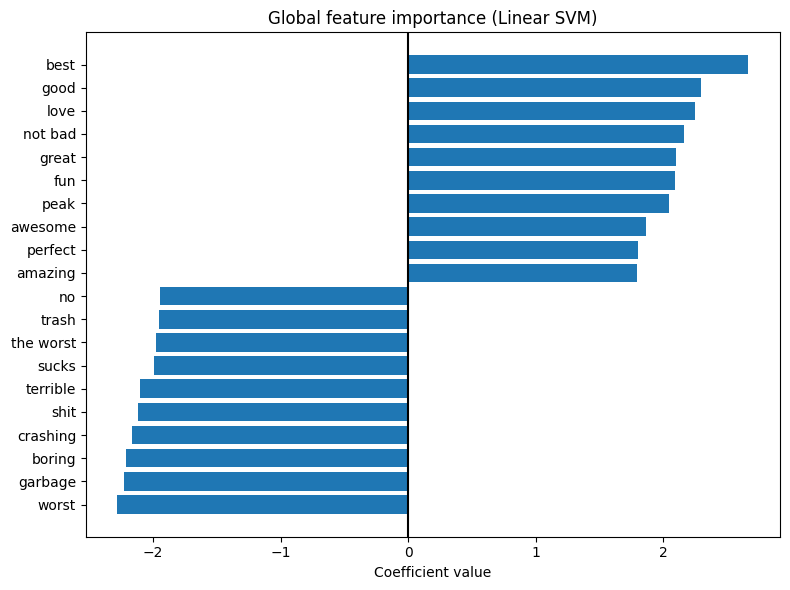

In [32]:
# Coefficients of the linear SVM
coef_df = pd.DataFrame({
    "word": feature_names_t,
    "coef": coefs_t
})

# Selection
top_pos = coef_df.sort_values("coef", ascending=False).head(10)
top_neg = coef_df.sort_values("coef", ascending=True).head(10)

top_pos = top_pos.sort_values("coef", ascending=True)

# Concatenation
top = pd.concat([top_neg, top_pos])

# Plot
plt.figure(figsize=(8, 6))
plt.barh(top["word"], top["coef"])
plt.axvline(0, color="black")
plt.title("Global feature importance (Linear SVM)")
plt.xlabel("Coefficient value")
plt.tight_layout()
plt.show()

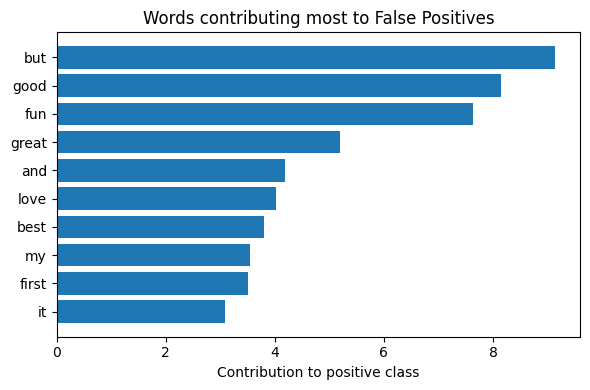

In [ ]:
# Words contributing most to False Positives
fp_words = discriminant_table(X, idx_fp, "FP", top_n=50)

# Only positive contributions
fp_words = (
    fp_words[fp_words["contribution_FP"] > 0] # Words pushing to positive class
    .sort_values("contribution_FP", ascending=False)
    .head(10)
)

plt.figure(figsize=(6, 4))
plt.barh(fp_words["word"], fp_words["contribution_FP"])
plt.gca().invert_yaxis()  # Invert y-axis to have the highest on top
plt.title("Words contributing most to False Positives")
plt.xlabel("Contribution to positive class")
plt.tight_layout()
plt.show()


Les faux positifs sont principalement causés par la présence de mots à connotation positive isolés, tels que "good", "fun" ou "great", qui suffisent à faire basculer la prédiction vers la classe positive malgré un avis globalement négatif.

Le classifieur TF-IDF accorde un poids important à des marqueurs discursifs comme "but", qu’il associe à tort à une polarité positive en raison de leur cooccurrence fréquente avec des expressions positives.

In [34]:
tp_words = discriminant_table(X, idx_tp, "TP", top_n=10)

display(fp_words)
display(tp_words)


,word,contribution_FP
1,but,9.139548
3,good,8.149469
5,fun,7.638765
8,great,5.192975
12,and,4.182300
13,love,4.025134
14,best,3.796230
15,my,3.539909
16,first,3.501325
19,it,3.085791


,word,contribution_TP
0,fun,158.211002
1,good,151.799236
2,great,140.097999
3,best,126.200196
4,love,116.101098
5,is,-92.397703
6,but,87.970509
7,to,-86.822825
8,10,74.668773
9,this,-72.037361


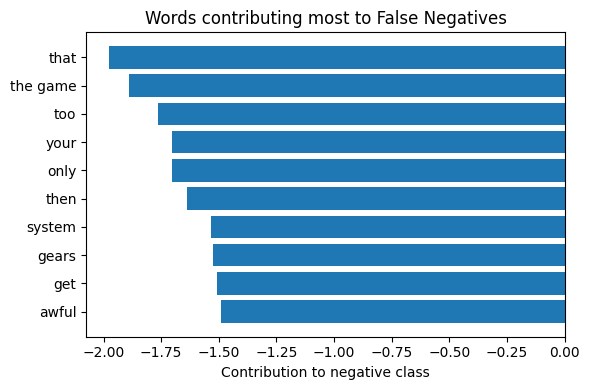

In [37]:
# Words contributing most to False Positives
fn_words = discriminant_table(X, idx_fp, "FN", top_n=50)

# Only negative contributions
fn_words = (
    fn_words[fn_words["contribution_FN"] < 0] # Words pushing to negative class
    .sort_values("contribution_FN", ascending=False)
    .head(10)
)

plt.figure(figsize=(6, 4))
plt.barh(fn_words["word"], fn_words["contribution_FN"])
plt.title("Words contributing most to False Negatives")
plt.xlabel("Contribution to negative class")
plt.tight_layout()
plt.show()

Les faux négatifs sont majoritairement associés à des mots fonctionnels ou contextuels ("that", "too", "only", "then"), révélant que le modèle confond complexité linguistique et négativité.

Les avis positifs exprimant des nuances ou des concessions sont pénalisés par le classifieur TF-IDF, qui assimile la présence d’arguments ou de descriptions techniques à une critique négative. Le modèle tend ainsi à sous-estimer les avis positifs riches et argumentés, au profit d’avis courts et lexicalement explicites.

## III. Modèle issu de SBERT

Contrairement au modèle précédent, les classifieurs basés sur un embedding SBERT ne permettent pas une interprétation basée sur les mots, dans la mesure où les features correspondent à la sémantique de la review. C'est pourquoi l'analyse sera faite au niveau de la review.

In [38]:
# Trained model
model_s = joblib.load(PATH_SBERT)

embedder = model_s.named_steps["embed"]
clf = model_s.named_steps["clf"]

y_pred_s = model_s.predict(X)
scores_s = model_s.decision_function(X)

Batches: 100%|██████████| 161/161 [00:55<00:00,  2.92it/s]


In [39]:
# ROC-AUC
roc_auc = roc_auc_score(y, scores_s)

# Matrice de confusion
cm = confusion_matrix(y, y_pred_s)

print(f"ROC-AUC: {roc_auc:.4f}")
print("Confusion matrix:\n", cm)
print(classification_report(y, y_pred_s, digits=4))

ROC-AUC: 0.9014
Confusion matrix:
 [[ 883  191]
 [ 782 3296]]
              precision    recall  f1-score   support

           0     0.5303    0.8222    0.6448      1074
           1     0.9452    0.8082    0.8714      4078

    accuracy                         0.8111      5152
   macro avg     0.7378    0.8152    0.7581      5152
weighted avg     0.8587    0.8111    0.8241      5152



In [41]:
tp_s = (y == 1) & (y_pred_s == 1)
fp_s = (y == 0) & (y_pred_s == 1)
tn_s = (y == 0) & (y_pred_s == 0)
fn_s = (y == 1) & (y_pred_s == 0)

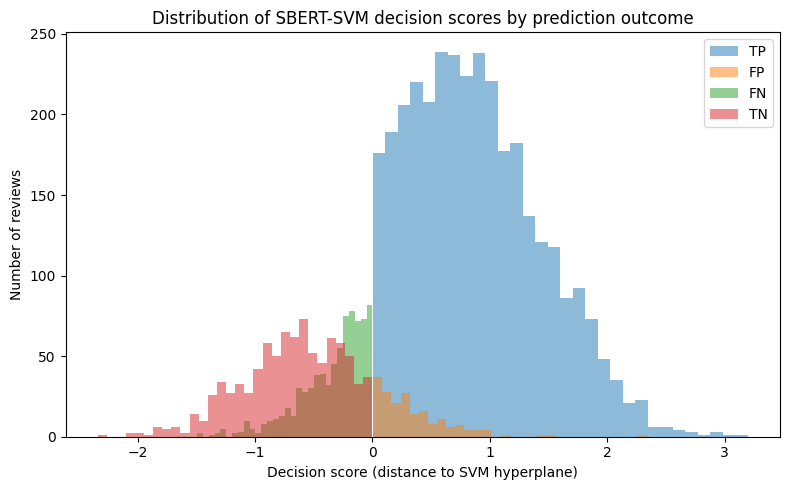

In [42]:
plt.figure(figsize=(8, 5))

plt.hist(scores_s[tp_s], bins=30, alpha=0.5, label="TP")
plt.hist(scores_s[fp_s], bins=30, alpha=0.5, label="FP")
plt.hist(scores_s[fn_s], bins=30, alpha=0.5, label="FN")
plt.hist(scores_s[tn_s], bins=30, alpha=0.5, label="TN")

plt.xlabel("Decision score (distance to SVM hyperplane)")
plt.ylabel("Number of reviews")
plt.title("Distribution of SBERT-SVM decision scores by prediction outcome")

plt.legend()
plt.tight_layout()
plt.show()


The score distribution highlights a clear separation between positive and negative reviews. False positives and false negatives are mostly located near the decision boundary, suggesting that misclassifications are driven by nuanced or mixed opinions rather than by systematic weaknesses of the classifier.

In [46]:
idx_fp_s = np.where((y == 0) & (y_pred_s == 1))[0]
idx_fn_s = np.where((y == 1) & (y_pred_s == 0))[0]
df.iloc[idx_fp_s[:10]][["review_text"]]
#df.iloc[idx_fn_s[:10]][["review_text"]]

,review_text
11,"Fun with friends for the first few days, then ..."
41,I'm only down thumbing because Steam does offe...
68,Wasn't my thing. Rather just play Helldivers
126,I really enjoy the game... but had to uninstal...
144,really boring not that fun ngl even my friend ...
234,"I really want to like this game, and I keep tr..."
248,fr one of the worst games ive ever played and ...
252,Its a no from me dawg. As shallow as sea of th...
259,nearly every time i do a pipline mission i get...
313,50 Minutes into a mission lost all collison on...


In [47]:
for i in idx_fp_s[:10]:
    print("—" * 80)
    print(df.loc[i, "review_text"])


————————————————————————————————————————————————————————————————————————————————
Fun with friends for the first few days, then the gameplay gets really boring, and repetitive. Like the free stuff they give but that is the only good thing I can think about this game, I would rather hangout in a Discord VC with friends playing nothing than play this game.
————————————————————————————————————————————————————————————————————————————————
I'm only down thumbing because Steam does offer an option in between.

This is a first person shooting miner style game where you drop in for missions and once complete you leave to return to a main hub. You have a few classes to choose from; all with their own weapons and gadgets. Your objective; go down and mine some resources to a certain amount or complete an objective. As you do; you deal with hordes of insect like creatures that make the planet their home. Differences in creatures is what you'd expect from a game like this. Some armored, some elementa

In [48]:
for i in idx_fn_s[:10]:
    print("—" * 80)
    print(df.loc[i, "review_text"])

————————————————————————————————————————————————————————————————————————————————
Прекрасная кооп игра. Если не считать того что происходит на 4-5+ хазардах, то я думаю ее можно назвать расслабляющей? Не жалею не единого рубля потраченного на эту игру
————————————————————————————————————————————————————————————————————————————————
why wouldnt you play this 10/10 best coop game ever
————————————————————————————————————————————————————————————————————————————————
Quick review: 5

### Metric ###
1- Garbage. :(
2- Did not fulfill the purpose.
3 - Ok, fulfilled the purpose.
4 - A good game!
5 - Just play and be happy. :)
————————————————————————————————————————————————————————————————————————————————
After well over 1000 hours I am still finding more nuance and intereting new gun builds in this game. Love every bit of it, shooter gameplay is deep and complex between the weapon upgrades and ocerclocks, hide and seek, soccer, and jetty boot minigames, incredible mission modifiers and events, a